# Passo 1

## Importações necessárias

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Definição de funções

### Função de leitura

In [2]:
def load_spam_collection(data_path, seed=123):
    spamfilter_df = pd.read_csv(data_path, delimiter='\t', header=None)
    spamfilter_df.columns = ['label', 'message']
    
    ''' 
        All labels were changed to the following classification: 
        spam is converted to 1 and ham to 0.
    '''
    spamfilter_df['label'] = spamfilter_df['label'].apply(
        lambda x: 1 if(x == 'spam')
        else 0
    )

    '''
    Adding an additional column that represents the number of letters 
    per message, thus creating a table that provides the sample size information.
    '''
    spamfilter_df['sample_length'] = spamfilter_df['message'].apply(lambda x: len(x))

    return spamfilter_df

### Funções de análise de dados

In [3]:
def get_num_documents(spamfilter_df):
    return spamfilter_df.count()['label']


def get_num_words_per_document(spamfilter_df):
    sample_message = spamfilter_df['message'].tolist()
    num_words = [len(s.split()) for s in sample_message]
    return np.median(num_words)


def get_num_classes(spamfilter_df):
    return spamfilter_df.nunique()['label']


def plot_sample_length_distribuition(spamfilter_df):
    sns.histplot(
        spamfilter_df['sample_length'],
        kde=True,
        bins=50,
        color='blue'
    )


def plot_class_distribuition(spamfilter_df):
    labels = spamfilter_df['label'].value_counts()
    lp = labels.plot(kind='barh', color=['#66c2a5', '#fc8d62'])
    lp.set_yticks([0, 1])
    lp.set_yticklabels(['Ham', 'Spam'])

## Aplicando a análise

In [ ]:
data_path = "data/SMSSpamCollection"  # You may need to change the directory on your machine for it to work.
spam_df = load_spam_collection(data_path)

spam_df.head()

,label,message,sample_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [5]:
num_doc = get_num_documents(spam_df)
print(f"Número total de documentos: {num_doc}")

Número total de documentos: 5572


In [6]:
num_word_per_document = get_num_words_per_document(spam_df)
print(f"Número médio de palavras por documento: {num_word_per_document}")

Número médio de palavras por documento: 12.0


In [7]:
num_classes = get_num_classes(spam_df)
print(f"Número de classes: {num_classes}")

Número de classes: 2


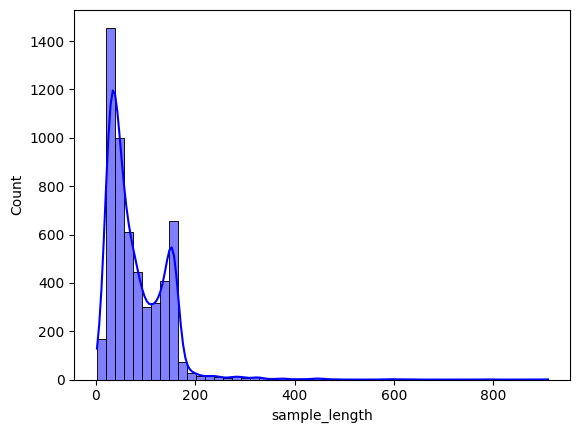

In [8]:
plot_sample_length_distribuition(spam_df)

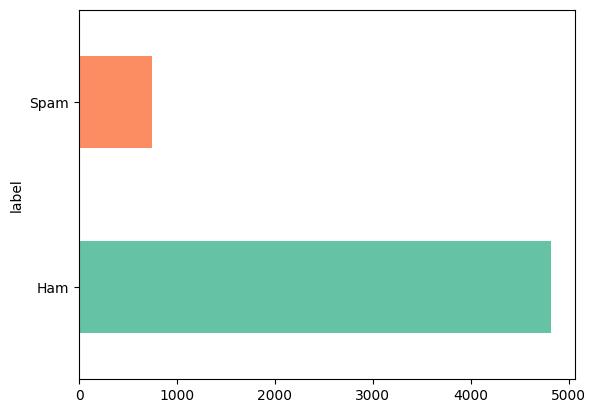

In [9]:
plot_class_distribuition(spam_df)

# Passo 2

## Importações necessárias

In [10]:
import spacy
import nltk
from nltk.stem import WordNetLemmatizer # utilizado para fazer lematização do texto
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re # biblioteca para utilizar expressão regulares
from wordcloud import WordCloud # biblioteca para criar uma núvem de palavras
import contractions # usado para expandir as possíveis contrações do texto

## Preprando dados para pré-processamento

In [11]:
nlp = spacy.load("en_core_web_sm")
stop_words = STOP_WORDS
# stop_words

In [12]:
punctuation = string.punctuation
# punctuation

In [13]:
nltk.download('wordnet') # download para fazer a lematização do texto usando WordNetLematizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Função que pré-processa os dados

In [14]:
def contraction_text(texts):
    ''' 
        This function is used to expand the possible hiring of some words in the text
    '''
    
    expanded_text = []
    for word in texts.split():
        expanded_text.append(contractions.fix(word))

    texts = ' '.join(expanded_text)
    
    return texts

In [15]:
def lemmatizer_text(texts):
    ''' 
    function responsible for lemmatizing the text
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    word_token = texts.split()
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in word_token]

    texts = ' '.join(lemmas)

    return texts

In [16]:
def processing(texts):
    texts = contraction_text(texts)
    texts = lemmatizer_text(texts)
    
    result = []
    pos_tag = ['ADJ', 'NOUN', 'VERB', 'PROPN'] # vetor que permite escolher somente entre adjetivos, substantivos, verbos e pronomes
    text = re.sub(r'(https?://[^\s\n\r]+|www\.[^\s\n\r]+|[0-9@#&!?:,.\)\(;])', '', texts) # expressão regular que retira do texto todos os números, simbolos (&#;) e URL
    doc = nlp(text.lower())

    for token in doc:
        if(token.text in stop_words or token.text in punctuation or len(token.text) <= 3 or token.text == "ltgt"):
            continue
        
        if(token.pos_ in pos_tag):
            result.append(token.text)
        
        text = ' '.join(str(element) for element in result if not element.isdigit())
    
    return text

## Aplicando o pré-processamento

In [17]:
spam_df.message = spam_df.message.astype(str)
spam_df['processed_message'] = spam_df['message'].apply(processing)

spam_df.head()

,label,message,sample_length,processed_message
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,joking
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp final tkts text receive e...
3,0,U dun say so early hor... U c already then say...,49,early
4,0,"Nah I don't think he goes to usf, he lives aro...",61,think live


## Vizualização do resultado final

In [18]:
total_message = spam_df['processed_message'].values
result_total_message = ''

for word in total_message:
    result_total_message += word + " "

# result_total_message

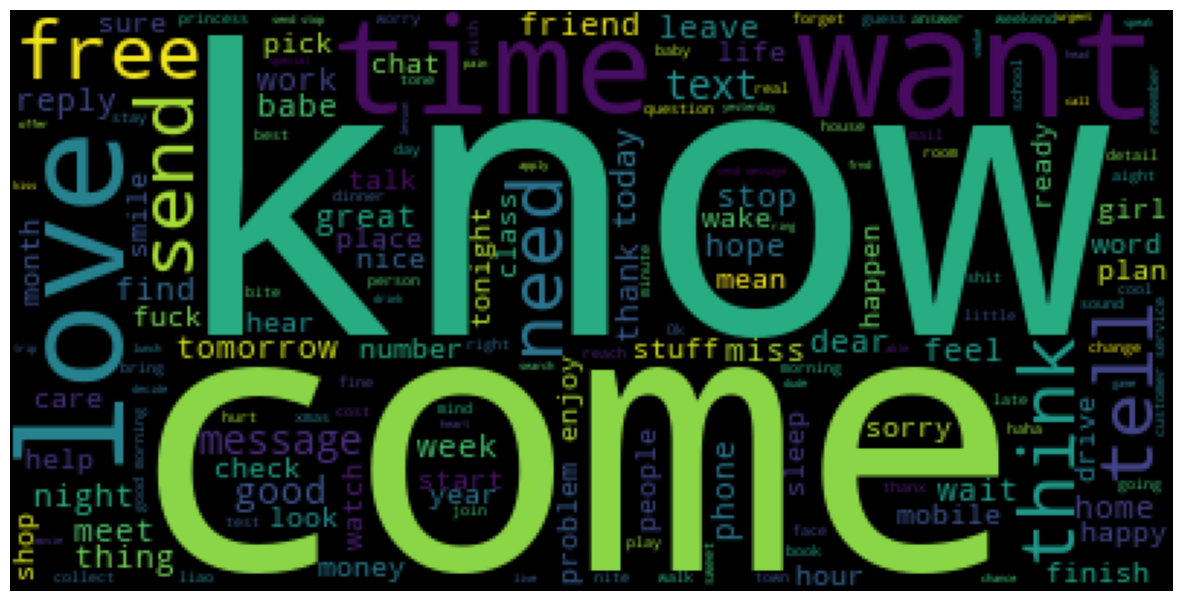

In [19]:
'''
Vizualizando o resultado final do pré-processamento
com núvem de palavras
'''
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(WordCloud().generate(result_total_message))

# Passo 3

## Importações necessárias

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Dados separados para treino e testes

In [21]:
'''
80% para treino e 20% para teste. Mantendo a proporção de emails spam e ham.
Utilizando para isso o parâmetro stratify.
'''

X_train, X_test, y_train, y_test = train_test_split(
    spam_df['processed_message'],
    spam_df['label'],
    test_size=0.2,
    stratify=spam_df['label'],
    random_state=42
)

## Função de vetorização que utiliza TF-IDF

In [22]:
def tfid_vectorize(X_train, X_test):
    vectorizer = TfidfVectorizer()

    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)

    return x_train, x_test

In [23]:
vecX_train, vecX_test = tfid_vectorize(X_train, X_test)

# Passo 4

## Importações necessárias

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

## Modelo SVM

### Vizualização dos dados de treinamento

In [25]:
'''
Como o  TF-IDF gera uma representação de alta dimensão, 
foi utilizado a técnica PCA (Principal Component Analysis): 
Reduz as dimensões mantendo a maior variância dos dados e ajuda
a visualizar a distribuição. Para, portanto, determinar 
se os dados têm uma relação linear ou polinomial
'''
pca = PCA(n_components=2)
vecX_pca = pca.fit_transform(vecX_train.toarray())

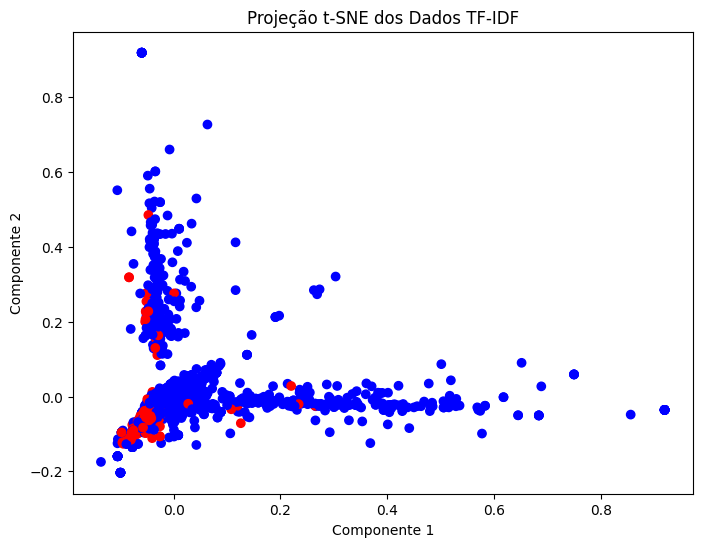

In [26]:
colors = ['blue' if label == 0 else 'red' for label in y_train]

plt.figure(figsize=(8, 6))
plt.scatter(vecX_pca[:, 0], vecX_pca[:, 1], c=colors, alpha=1)
plt.title('Projeção t-SNE dos Dados TF-IDF')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

### Treinamento do modelo

In [27]:
model_spam_filtter = svm.SVC(kernel='linear', C=1.0)
model_spam_filtter.fit(vecX_train, y_train)

y_pred = model_spam_filtter.predict(vecX_test)

### Métricas do modelo

In [28]:
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))
print()

print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_spam_filtter.score(vecX_test, y_test)*100:,.2f}")

Matriz de confusão
[[958   8]
 [ 24 125]]

F1: 88.65
Acurácia: 97.13


## Modelo K-NN

### Treinamento do modelo

In [29]:
model_knn_spam = KNeighborsClassifier(n_neighbors=3)
model_knn_spam.fit(vecX_train, y_train)

y_pred = model_knn_spam.predict(vecX_test)

### Métricas do modelo

In [30]:
print("Matriz de confusão: ")
print(confusion_matrix(y_test, y_pred))
print()
print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_knn_spam.score(vecX_test, y_test)*100:,.2f}")

Matriz de confusão: 
[[965   1]
 [ 78  71]]

F1: 64.25
Acurácia: 92.91


## Modelo Decision Trees

### Treinamento do modelo

In [31]:
model_tree_spam = DecisionTreeClassifier()
model_tree_spam.fit(vecX_train, y_train)

y_pred = model_tree_spam.predict(vecX_test)

### Métricas do modelo

In [32]:
print("Matiz de confusão:")
print(confusion_matrix(y_test, y_pred))
print()
print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_spam_filtter.score(vecX_test, y_test)*100:,.2f}")

Matiz de confusão:
[[945  21]
 [ 27 122]]

F1: 83.56
Acurácia: 97.13


# Passo 5

## Importações necessárias

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

## Definições de Hiperparâmetros

In [34]:
svm_params = {'svm__C': [0.1, 1, 10], 
              'svm__kernel': ['linear', 'rbf', 'poly'], 
              'svm__gamma': [0.001, 0.1, 1]}

knn_params = {'knn__n_neighbors': [3, 5, 7, 9],
              'knn__metric': ['euclidian', 'manhattan'],
              'knn__weights': ['uniform', 'distance'],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

decision_tree_params = {'dt__criterion': ['gini', 'entropy'],
                 'dt__splitter':['best', 'random'],
                 'dt__min_samples_leaf':[2, 5, 10],
                 'dt__max_depth':[3, 5, 10], 
                 'dt__min_samples_split':[2, 5, 10]}

## Inicialização de modelos

In [35]:
pipeline_svm = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC())
    ]
)
pipeline_knn = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('knn', KNeighborsClassifier())
    ]
)
pipeline_dt = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier())
    ]
)

## Método GridSearchCV

In [36]:
grid_svm = GridSearchCV(pipeline_svm, param_grid=svm_params, scoring='f1_macro')
grid_knn = GridSearchCV(pipeline_knn, param_grid=knn_params, scoring='f1_macro')
grid_dt = GridSearchCV(pipeline_dt, param_grid=decision_tree_params, scoring='f1_macro')

In [37]:
X = spam_df['processed_message']
y = spam_df['label']

grid_svm.fit(X, y)
grid_knn.fit(X, y)
grid_dt.fit(X, y)

c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\sk

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [3, 5, 10],
                         'dt__min_samples_leaf': [2, 5, 10],
                         'dt__min_samples_split': [2, 5, 10],
                         'dt__splitter': ['best', 'random']},
             scoring='f1_macro')

## Vizualização de resultado

In [38]:
print("SVM: ", grid_svm.best_params_)
print(f"F1_score: {grid_svm.best_score_*100:,.2f}", )
print()
print("KNN: ", grid_knn.best_params_)
print(f"F1_score: {grid_knn.best_score_*100:,.2f}")
print()
print("Decision Tree", grid_dt.best_params_)
print(f"F1_score: {grid_dt.best_score_*100:,.2f}")

SVM:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
F1_score: 93.88

KNN:  {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
F1_score: 49.26

Decision Tree {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10, 'dt__splitter': 'best'}
F1_score: 83.88


# Passo 6

## Importações necessárias

In [39]:
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from scipy import stats
from statsmodels.stats.multitest import multipletests

## Aplicando a validação cruzada

In [40]:
'''
X é todos os documentos já com as mensagens processadas,
y são os rótulos referentes a cada documento dizendo se é
spam (1) ou ham (0)

Essa separação é realizada novamente, pois a representação TF-IDF será
feita somente dentro da própria validação cruzada, isto é, somente quando
todos os K-1 conjuntos de treinos e 1 conjunto de teste forem separados e escolhidos
'''

X = spam_df['processed_message']
y = spam_df['label']


In [41]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
print(skf)

StratifiedKFold(n_splits=10, random_state=123, shuffle=True)


In [42]:
'''
vetores que guardarão os f1_score,
representando o desempenho de cada modelo 
em cada K folds.
''' 

f1_score_svm = []
f1_score_knn = []
f1_score_tree = []

for train_index, test_index in skf.split(X, y):

    #Separação manual dos conjuntos de treino e teste    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #vetorização desses conjuntos
    vecXskf_train, vecXskf_test = tfid_vectorize(X_train=X_train, X_test=X_test)

    # modelos treinados e testados a partir dos folds criados em cada iteração do for
    model_spam_filtter_svm = svm.SVC(C= 10, gamma= 0.1, kernel= 'rbf')
    model_spam_filtter_svm.fit(vecXskf_train, y_train)
    y_pred = model_spam_filtter_svm.predict(vecXskf_test)

    f1_score_svm.append(f1_score(y_test, y_pred))
    
    model_knn_spam_skf = KNeighborsClassifier(algorithm= 'auto', metric= 'manhattan', n_neighbors= 3, weights= 'distance')
    model_knn_spam_skf.fit(vecXskf_train, y_train)
    y_pred = model_knn_spam_skf.predict(vecXskf_test)

    f1_score_knn.append(f1_score(y_test, y_pred))
    
    model_tree_spam_skf = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, min_samples_leaf= 2, min_samples_split= 10, splitter= 'random')
    model_tree_spam_skf.fit(vecXskf_train, y_train)
    y_pred = model_tree_spam_skf.predict(vecXskf_test)

    f1_score_tree.append(f1_score(y_test, y_pred))

f1_score_svm = np.array(f1_score_svm)
f1_score_knn = np.array(f1_score_knn)
f1_score_tree = np.array(f1_score_tree)
    

## Comparação dos modelos

In [43]:
media_f1_svm = np.mean(f1_score_svm)
media_f1_knn = np.mean(f1_score_knn)
media_f1_tree = np.mean(f1_score_tree)

dp_f1_svm = np.std(f1_score_svm)
dp_f1_knn = np.std(f1_score_knn)
dp_f1_tree = np.std(f1_score_tree)

print("=============== SVM ===============")
print(f"Media: {media_f1_svm * 100:,.2f}")
print(f"Desvio Padrão: {dp_f1_svm * 100:,.2f}")

print("=============== KNN ===============")
print(f"Media: {media_f1_knn * 100:,.2f}")
print(f"Desvio Padrão: {dp_f1_knn * 100:,.2f}")

print("=============== Tree ===============")
print(f"Media: {media_f1_tree * 100:,.2f}")
print(f"Desvio Padrão: {dp_f1_tree * 100:,.2f}")

=============== SVM ===============
Media: 90.74
Desvio Padrão: 2.22
=============== KNN ===============
Media: 75.64
Desvio Padrão: 3.58
=============== Tree ===============
Media: 69.21
Desvio Padrão: 3.91


## Teste T com correção Bonferroni

In [44]:
saidaH = {
    'SVM': f1_score_svm,     # Array com F1-scores do SVM
    'KNN': f1_score_knn,     # Array com F1-scores do KNN
    'Decision Tree': f1_score_tree  # Array com F1-scores da Decision Tree
}

saidaH_teste = []

pares = list(itertools.combinations(saidaH.keys(), 2))

# Número de testes realizados (correção de Bonferroni)
n_testes = len(pares)

for metodo_a, metodo_b in pares:
    valores_a = saidaH[metodo_a]
    valores_b = saidaH[metodo_b]
    
    # Teste t
    t_stat, p_val = stats.ttest_ind(valores_a, valores_b)
    
    # Correção de Bonferroni
    p_val_corrigido = p_val * n_testes
    
    if p_val_corrigido < 0.05:
        comparacao = "estatisticamente diferente"
    else:
        comparacao = "não estatisticamente diferente"
    
    saidaH_teste.append({
        'metodo_a': metodo_a,
        'metodo_b': metodo_b,
        'comparacao': comparacao
    })


for resultado in saidaH_teste:
    print(f"Método A: {resultado['metodo_a']}, Método B: {resultado['metodo_b']}")
    print(f"Comparação: {resultado['comparacao']}")
    print("-" * 50)

Método A: SVM, Método B: KNN
Comparação: estatisticamente diferente
--------------------------------------------------
Método A: SVM, Método B: Decision Tree
Comparação: estatisticamente diferente
--------------------------------------------------
Método A: KNN, Método B: Decision Tree
Comparação: estatisticamente diferente
--------------------------------------------------


# Passo 7

## Importações necessárias

In [45]:
from gensim.models import Word2Vec, FastText

## Separação dos dados

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    spam_df['processed_message'],
    spam_df['label'],
    test_size=0.2,
    stratify=spam_df['label'],
    random_state=42
)

''' 
Separa cada sms em um vetor de palavras para que 
cada palavra receba seu respectivo vetor no seu espaço 
de embeddings
'''
X_train_tokenized = [text.split() for text in X_train]

'''
Separação dos dados para evitar que haja um leakage de informação,
onde os dados de teste possam influenciar o modelo, resultando em desempenho
irreal
'''

'\nSeparação dos dados para evitar que haja um leakage de informação,\nonde os dados de teste possam influenciar o modelo, resultando em desempenho\nirreal\n'

## Representação do texto utilizando word embedding's

In [47]:
model_w2v = Word2Vec(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2
)

model_fasttext = FastText(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2
)

In [48]:
def vectorize_embeddings(model, text):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [49]:
X_train_vectors_w2 = np.array([vectorize_embeddings(model_w2v, text) for text in X_train_tokenized])
X_train_vectors_fasttext = np.array([vectorize_embeddings(model_fasttext, text) for text in X_train_tokenized])

In [50]:
X_test_vectors_w2 = np.array([vectorize_embeddings(model_w2v, text.split()) for text in X_test])
X_test_vectors_ft = np.array([vectorize_embeddings(model_fasttext, text.split()) for text in X_test])

## Treinamento dos modelos utilizando Word2Vec

In [52]:
model_knn_spam = KNeighborsClassifier()
model_svm_spam = svm.SVC()
model_dt_spam = DecisionTreeClassifier()

model_svm_spam.fit(X_train_vectors_w2, y_train)
model_knn_spam.fit(X_train_vectors_w2, y_train)
model_dt_spam.fit(X_train_vectors_w2, y_train)

y_pred_svm = model_svm_spam.predict(X_test_vectors_w2)
y_pred_knn = model_knn_spam.predict(X_test_vectors_w2)
y_pred_dt = model_dt_spam.predict(X_test_vectors_w2)


In [53]:
print("=============================== Métricas SVM ===============================")
print(classification_report(y_test, y_pred_svm))
print("=============================== Métricas KNN ===============================")
print(classification_report(y_test, y_pred_knn))
print("=============================== Métricas DT ===============================")
print(classification_report(y_test, y_pred_dt))

=============================== Métricas SVM ===============================
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       966
           1       0.91      0.27      0.41       149

    accuracy                           0.90      1115
   macro avg       0.90      0.63      0.68      1115
weighted avg       0.90      0.90      0.87      1115

=============================== Métricas KNN ===============================
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       966
           1       0.59      0.78      0.67       149

    accuracy                           0.90      1115
   macro avg       0.78      0.85      0.81      1115
weighted avg       0.91      0.90      0.90      1115

=============================== Métricas DT ===============================
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       966
       

## Treinamento dos modelos utilizando FastText

In [56]:
model_knn_spam = KNeighborsClassifier()
model_svm_spam = svm.SVC()
model_dt_spam = DecisionTreeClassifier()

model_svm_spam.fit(X_train_vectors_fasttext, y_train)
model_knn_spam.fit(X_train_vectors_fasttext, y_train)
model_dt_spam.fit(X_train_vectors_fasttext, y_train)

y_pred_svm = model_svm_spam.predict(X_test_vectors_ft)
y_pred_knn = model_knn_spam.predict(X_test_vectors_ft)
y_pred_dt = model_dt_spam.predict(X_test_vectors_ft)

In [57]:
print("=============================== Métricas SVM ===============================")
print(classification_report(y_test, y_pred_svm))
print("=============================== Métricas KNN ===============================")
print(classification_report(y_test, y_pred_knn))
print("=============================== Métricas DT ===============================")
print(classification_report(y_test, y_pred_dt))

=============================== Métricas SVM ===============================
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

=============================== Métricas KNN ===============================
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       966
           1       0.39      0.49      0.43       149

    accuracy                           0.83      1115
   macro avg       0.65      0.68      0.67      1115
weighted avg       0.85      0.83      0.84      1115

=============================== Métricas DT ===============================
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       966
       

c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\OneDrive\Desktop\NLP-Applications\nlp\exercicio1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c